<a href="https://colab.research.google.com/github/raeubaen/giagu/blob/master/NB_randomforest_ising2D_LC1_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione stato di un modello di Ising 2D con Random Forests

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/My Drive'
# Ho Google Drive montato localmente col file-system FUSE
except (ModuleNotFoundError, KeyError):
    drive_path = '/home/ruben/google-drive' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Informazioni ###

* Scopo: imparare ad usare ensamble di modelli deboli tipo foreste random di alberi a decisione binaria 
* applicazione: classificazione dello fase in cui si trovano configurazioni di un modello di Ising 2D <br>
* ML tool: scikit-learn


### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

100k configurazioni con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis. 

Il campione è disponibile qui:

* [configurazioni](https://www.dropbox.com/s/ma1n1r2uejb9iei/ising_conf.dat?dl=0)
* [label](https://www.dropbox.com/s/dj1urxh8tsadoh5/ising_label.dat?dl=0)

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

Poiché è noto che vicino alla temepratura critica $T_c$, la lunghezza delle correlazioni ferromagnetiche diverge, rendendo difficile identificare la fase, dvideremo il campione in tre sotto-campioni:

* ordinato: $T/J<2.0$
* critico: $2.0\leq T/J\leq 2.5$
* disordinato: $T/J>2.5$

e addestreremo il modello usando solo le configurazioni ordinate e disordinate. Poi testeremo il tutto su tutte le configurazioni.

### Parte 1: load e pre-processamento del dataset ###

In [0]:
import numpy as np

np.random.seed() # shuffle random seed generator

# Ising model parameters
L = 28 # size del reticolo
J = 1.0 # Ising interaction (1 ferromagnetico, -1 anti-ferromagnetico)
T_c = 2.26 # Temperatura critica

In [0]:
#leggiamo le configurazioni ising dal file usando numpy 
# (100k esempi oguno da 28x28 spin)
file_name = f"{drive_path}/Colab Notebooks/dataset/ising_conf.dat"
data = np.loadtxt(file_name)
print(data.shape)

(2800000, 28)


NOTA: gli esempi sono scritti nel file come righe sequenziali da 28 valori l'una -> 100k x 28 = 2800000 

In [0]:
# al fine di visualizzare alcune delle configurazioni 
# convertiamo il vettore numpy in un tensore di 100K eventi ognuno 
# formato da una matrice 28x28 di spin
data = data.reshape(100000,28,28)
print(f"Data shape: {data.shape}")
conf_num = data.shape[0]

Data shape: (100000, 28, 28)


In [0]:
#esempio
import pandas as pd
rnd = np.random.randint(0, conf_num)
#stampa un evento come una matrice 28x28 di valori dello spin (-1,1)
print(pd.DataFrame(data[rnd]))

     0    1    2    3    4    5    6   ...   21   22   23   24   25   26   27
0   1.0  1.0  1.0  1.0 -1.0  1.0 -1.0  ...  1.0 -1.0  1.0 -1.0  1.0  1.0 -1.0
1   1.0  1.0  1.0  1.0 -1.0  1.0  1.0  ... -1.0 -1.0 -1.0 -1.0  1.0  1.0  1.0
2  -1.0  1.0  1.0  1.0 -1.0 -1.0  1.0  ...  1.0 -1.0 -1.0 -1.0  1.0  1.0  1.0
3  -1.0  1.0 -1.0 -1.0 -1.0  1.0 -1.0  ... -1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0
4   1.0  1.0 -1.0 -1.0 -1.0  1.0  1.0  ... -1.0 -1.0 -1.0  1.0  1.0  1.0 -1.0
5  -1.0 -1.0  1.0 -1.0  1.0  1.0  1.0  ... -1.0 -1.0 -1.0  1.0  1.0  1.0 -1.0
6  -1.0 -1.0 -1.0 -1.0 -1.0  1.0  1.0  ... -1.0  1.0 -1.0  1.0 -1.0 -1.0 -1.0
7  -1.0  1.0 -1.0  1.0  1.0  1.0  1.0  ... -1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0
8  -1.0  1.0 -1.0 -1.0 -1.0  1.0  1.0  ... -1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0
9  -1.0  1.0  1.0  1.0 -1.0  1.0 -1.0  ... -1.0  1.0  1.0 -1.0  1.0 -1.0 -1.0
10  1.0  1.0  1.0  1.0 -1.0  1.0 -1.0  ... -1.0 -1.0  1.0  1.0 -1.0 -1.0 -1.0
11 -1.0  1.0  1.0  1.0 -1.0  1.0  1.0  ... -1.0  1.0  1.0  1.0  

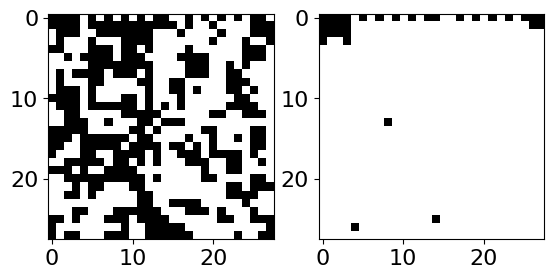

In [0]:
# plotta come un immagine la matrice precedente e quella successiva nell'array
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("default")
def plot_conf(axarr, data_list, titles_list):
  cmap_args=dict(cmap='binary')
  for i in range(len(data_list)):
    axarr[i].imshow(data_list[i], **cmap_args)
    axarr[i].set_title(titles_list[i], fontsize=16)
    axarr[i].tick_params(labelsize=16)

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=2)
plot_conf(axarr, [data[rnd], data[rnd-1]], ["", ""])
plt.show()


In [0]:
#leggiamo da file le label associate:
labels = np.loadtxt(f"{drive_path}/Colab Notebooks/dataset/ising_label.dat")
print(labels.shape)
print(f"T/J: {labels[rnd]}") #T/J della configurazione dell'evento mostrato prima

(100000,)
T/J: 4.16498


In [0]:
# dividiamo il campione in 3 campioni sulla base dello stato 
# (ordinato, critico, disordinato)
# T/J < 2.0 ordinato
# T/J > 2.5 disordinato
# altrimenti critico

ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))
    
data_ord, n_ord = data[ord_sele], np.sum(ord_sele)
data_dis, n_dis = data[dis_sele], np.sum(dis_sele)
data_cri, n_cri = data[cri_sele], np.sum(cri_sele)

print(f"Number of ordered configurations:\t{n_ord}") 
print(f"Number of disordered configurations:\t{n_dis}") 
print(f"Number of critical configurations:\t{n_cri}") 

labels_ord = np.zeros(data_ord.shape[0])
labels_dis = np.ones(data_dis.shape[0])
labels_critic = labels[cri_sele]

labels_cri = labels_critic.copy()
labels_cri[labels_critic>T_c] = 1
labels_cri[labels_critic<=T_c] = 0

print(f"Ordered Conf. labels:\t\t\t{labels_ord}")
print(f"Disordered Conf. labels:\t\t{labels_dis}")
print(f"Critical Conf. labels:\t\t\t{labels_cri}")

Number of ordered configurations:	40177
Number of disordered configurations:	50015
Number of critical configurations:	9808
Ordered Conf. labels:			[0. 0. 0. ... 0. 0. 0.]
Disordered Conf. labels:		[1. 1. 1. ... 1. 1. 1.]
Critical Conf. labels:			[1. 0. 0. ... 1. 0. 1.]


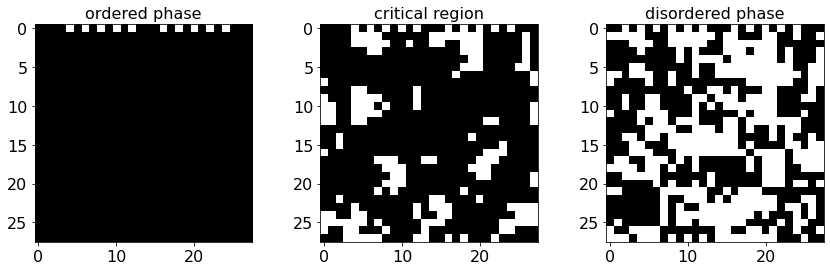

In [0]:
# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

plot_conf(
    axarr, 
    [data_ord[4], data_cri[4], data_dis[4]], 
    ['ordered phase', 'critical region', 'disordered phase'],
)

fig.subplots_adjust(right=2.0)
plt.show()

In [0]:
##Dividiamo il campione per il training
from sklearn.model_selection import train_test_split

train_to_test_ratio = 0.8 # training samples

# define training and test data sets
X = np.concatenate((data_ord,data_dis))
Y = np.concatenate((labels_ord,labels_dis))

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    train_size=train_to_test_ratio,
    test_size=1.0 - train_to_test_ratio
)

X_critical = data_cri
Y_critical = labels_cri

print('X_train shape:', X_train.shape)
print(f'Y_train shape: {Y_train.shape}\n')
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

# riformattiamo i tensori in modo che abbiano 
# l'input corretto atteso dagli alberi a decisione binaria 
# (vettori flat di features)   (N,28,28) -> (N, 28*28 = 784)

X_train = np.reshape(X_train, (X_train.shape[0], 28*28))
X_test = np.reshape(X_test, (X_test.shape[0], 28*28))
X_critical = np.reshape(X_critical, (X_critical.shape[0], 28*28))

train_test_critical = (X_train, Y_train, X_test, Y_test, X_critical, Y_critical)

X_train shape: (72153, 28, 28)
Y_train shape: (72153,)

72153 train samples
9808 critical samples
18039 test samples


### Parte 2: addestramento della Random Forests

**Iperparametri**

Usiamo l'implementazione in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) che ha due iperparamteri principali che possono modificare anche sensibimente le prestazioni del modello e il livelo di overfit/underfit: il numero di alberi nella foresta e la complessità di ciascun albero: il primo è controllato dal parametro `n_estimators`, mentre la complesiità è controllata da vari parametri `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc, in parte correlati tra loro. Nell'esempio in esame per semplicità useremo solo `min_samples_split` (governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero.

**NOTA: Stime OOB (Out of Bag)**

È un metodo molto utile per ottimizzare gli iperparametri quando si usano metodi di bagging: consiste nel verificare quanto bene funziona il classificatore su quegli eventi del training set che non sono stati usati nel training (perchè non campionati nella technica di boostrap). Gioca un ruolo simile alla k-fold cross-validation.

In [0]:
## Abbiamo modificato il codice originale
## rendendolo una funzione, cosicché potesse implementare anche
## altri classificatori o la k-fold CV

# La funzione è scritta per implementare un classificatore
# di sklearn valutabile con CV o, in modo opzionale,
# con OOB (se effettua bagging).
# Essa effettua inoltre Grid Search su due liste di iperparametri.

# Scikit-learn Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import time
import warnings

#Valore del numero di alberi 
min_estimators = 10
max_estimators = 101

#testiamo 10 valori per il primo iperparametro
n_estimator_range = np.arange(min_estimators, max_estimators, 10) 

#testiamo due valori per il seocondo iperparametro 
# (alta segmentazione e bassa segmentazione)
leaf_size_list = [2, 10000] 

def train_and_plot(
    X_train, Y_train, X_test, Y_test, X_critical, Y_critical, 
    classifier=RandomForestClassifier, 
    # la key è il nome del keyword argument del classificatore
    # il valore è la lista di valori da testare
    test_par={
        "min_samples_split": leaf_size_list,
        "n_estimators": n_estimator_range,
    },
    default_par={
        "n_estimators": min_estimators,
        "random_state": 0,
        "warm_start": True,
        # For a RFC, when set to True, reuses the solution of the previous call to fit and 
        # adds more estimators to the ensemble, otherwise fits a new forest.
    },
    ev_method="OOB", n_folds=5, print_flag=True, 
):
    
    # disabilitiamo messaggi di warning 
    warnings.filterwarnings("ignore")
    
    # Process hyperpars
    key1, key2 = test_par.keys()
    list1, list2 = test_par[key1], test_par[key2]
    #Allocate Arrays for various quantities
    m = len(list1)
    n = len(list2)
    train_acc, oob_or_cv_acc, test_acc, crit_acc, run_time = np.zeros((5, m, n))
    for i, value1 in enumerate(list1):
        # Definiamo il classificatore
        # Va definito qui e non sopra
        # perché il n-estimators può solo aumentare
        # (sklearn ha definito un'eccezione altrimenti,
        # nel caso di warn_start ON.)
        clf = classifier(**default_par)
        if ev_method == "OOB":
            try:
                clf.set_params(oob_score=True)
            except TypeError:
                print("The chosen classifier does not support OOB.")
                return
        elif ev_method == "CV":
            skf = StratifiedKFold(n_splits=n_folds) 
        else:
            raise ValueError("Specify ev_method between OOB or CV.")
    
        clf.set_params(**{key1: value1})
            
        for j, value2 in enumerate(list2):

            print(f'{key1}: {value1}, {key2}: {value2}')

            start_time = time.time()
            clf.set_params(**{key2: value2})
            if ev_method == "OOB":
                clf.fit(X_train, Y_train)
            else:
                scores = []
                for train_index, test_index in skf.split(X_train, Y_train):
                  X_cv_train, X_cv_test = X_train[train_index], X_train[test_index]
                  Y_cv_train, Y_cv_test = Y_train[train_index], Y_train[test_index]
                  clf.fit(X_cv_train, Y_cv_train)
                  scores.append(clf.score(X_cv_test, Y_cv_test))
                    
            run_time[i,j] = time.time() - start_time

            # check accuracy
            train_acc[i,j] = clf.score(X_train, Y_train)
            if ev_method == "OOB":
                oob_or_cv_acc[i,j] = clf.oob_score_
            else:
                oob_or_cv_acc[i,j] = np.array(scores).mean()
            test_acc[i,j] = clf.score(X_test, Y_test)
            crit_acc[i,j] = clf.score(X_critical, Y_critical)
            if print_flag:
                result = (
                    train_acc[i,j], 
                    oob_or_cv_acc[i,j], 
                    test_acc[i,j], 
                    crit_acc[i,j],
                    run_time[i,j], 
                )
                print(
                    '{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format(
                        "train score", 
                        f"{ev_method} estimate",
                        "test score", 
                        "critical score",
                        "time (s)",
                    )
                )
                print(
                    '{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(
                        *result
                    )
                )
    return (train_acc, oob_or_cv_acc, test_acc, crit_acc, run_time)

In [0]:
out = train_and_plot(*train_test_critical)

**Grafico delle prestazioni:**

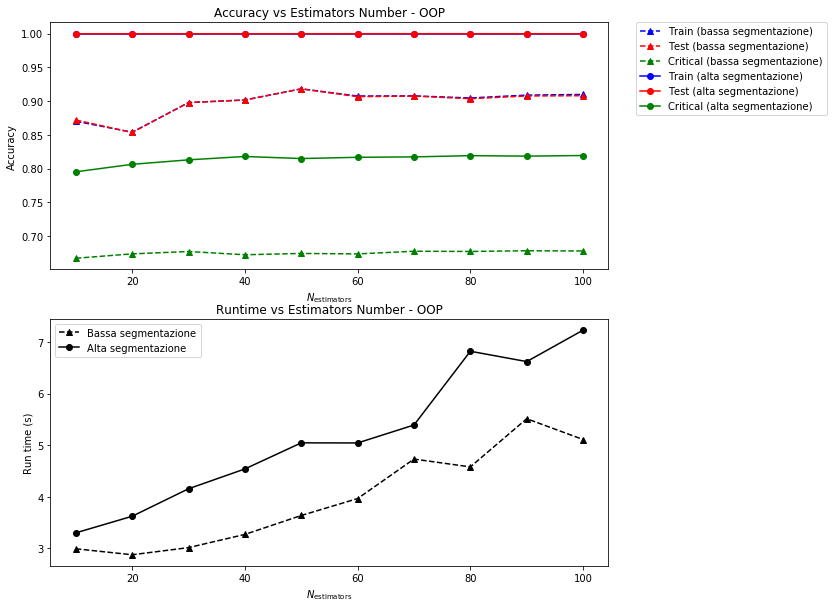

In [0]:
def plot_performance(train_acc, oob_or_cv_acc, test_acc, critic_acc, run_time):
    fig, axs = plt.subplots(2, figsize=(10, 10))
    ner = n_estimator_range
    ax0 = axs[0]
    ax0.plot(ner, train_acc[1],'--b^',label='Train (bassa segmentazione)')
    ax0.plot(ner, test_acc[1],'--r^',label='Test (bassa segmentazione)')
    ax0.plot(ner, critic_acc[1],'--g^',label='Critical (bassa segmentazione)')

    ax0.plot(ner, train_acc[0],'o-b',label='Train (alta segmentazione)')
    ax0.plot(ner, test_acc[0],'o-r',label='Test (alta segmentazione)')
    ax0.plot(ner, critic_acc[0],'o-g',label='Critical (alta segmentazione)')

    ax0.set(xlabel='$N_\mathrm{estimators}$', ylabel='Accuracy')
    lgd = ax0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    ax1 = axs[1]
    ax1.plot(ner, run_time[1], '--k^',label='Bassa segmentazione')
    ax1.plot(ner, run_time[0], 'o-k',label='Alta segmentazione')
    ax1.set(xlabel='$N_\mathrm{estimators}$', ylabel='Run time (s)')

    ax1.legend(loc=2)
    #plt.savefig("Ising_RF_Runtime.pdf")
    return (fig, axs)

fig, axs = plot_performance(*out)
axs[0].set(title="Accuracy vs Estimators Number - OOP")
axs[1].set(title="Runtime vs Estimators Number - OOP")
plt.show()

### Esercizi: ###  

* provate ad implementare un classificatore basato su un semplice albero di decisione binaria in scikitlearn e confrontare le prestazioni con la foresta random

* provate ad implementare un classificatore tipo gradient boost in scikitlearn 
  (*sklearn.ensemble.GradientBoostingClassifier*) ottimizzandone le prestazioni ed evitando overfitting e         confrontate con la foresta random

* provate a implementare invece che una validazione OOB (gratis con le foreste random in scikit-learn) una k-fold validation (con k=5 e 10) e verificate se vi sono differenze (OOB tende a dare delle stime molto pessimistiche).
    
NOTA: per imparare ad implementare una k-fold validation in scikit-learn guardate a questo [tutorial](https://scikit-learn.org/stable/modules/cross_validation.html)

* (opzionale) provate ad addestrare un modello gradient boost in regressione (*sklearn.ensemble.GradientBoostingRegressor*)che predica le temperature associate alle configurazioni del modello di ising

### Svolgimento degli esercizi
<b> Iniziamo implementando la k-fold CV sul modello appena utilizzato. </b> Abbiamo usato la `StratifiedKFold` di `sklearn`, che mantiene le proporzioni tra campioni con le stess label.

In [0]:
out = train_and_plot(*train_test_critical, ev_method="CV")

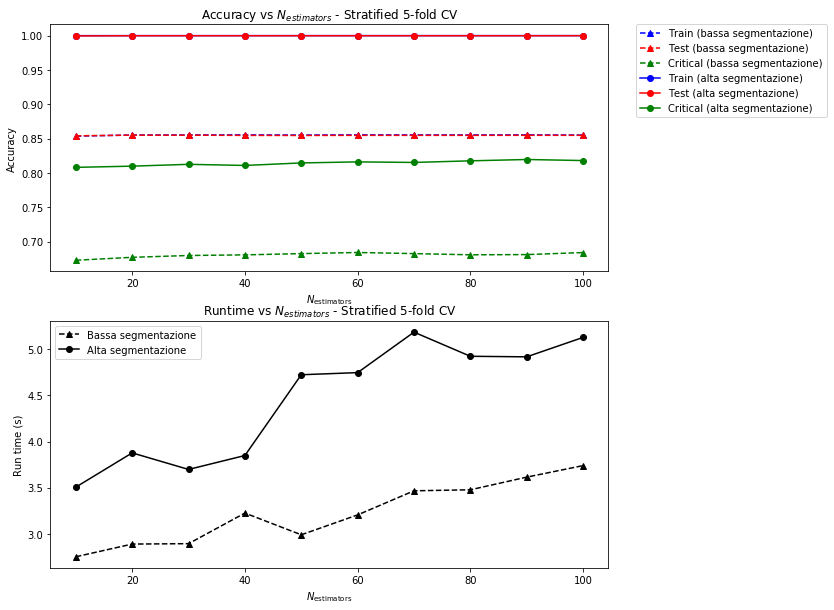

In [0]:
fig, axs = plot_performance(*out)
axs[0].set(title="Accuracy vs $N_{estimators}$ - Stratified 5-fold CV")
axs[1].set(title="Runtime vs $N_{estimators}$ - Stratified 5-fold CV")
plt.show()

Grazie al processo di media tra gli scores delle singole validazioni e grazie al fatto che, essendo il dataset in questione essenzialmente stocastico, i sottogruppi estratti con la stratified k-fold cross validation sono abbastanza indipendenti ed identicamente distribuiti, il cross-validation score in questo caso dà risutati identici allo score su tutto il training set, a differenza dell'OOP usato in precedenza.
Rieseguiamo lo stesso processo con `n_folds = 10`.

min_samples_split: 2, n_estimators: 10
train score    CV estimate    test score     critical score time (s)       
0.9999         0.9999         0.9998         0.8008         4.9261         
min_samples_split: 2, n_estimators: 20
train score    CV estimate    test score     critical score time (s)       
0.9999         0.9999         0.9998         0.8074         5.1686         
min_samples_split: 2, n_estimators: 30
train score    CV estimate    test score     critical score time (s)       
1.0000         1.0000         0.9998         0.8092         5.2557         
min_samples_split: 2, n_estimators: 40
train score    CV estimate    test score     critical score time (s)       
1.0000         1.0000         0.9998         0.8157         5.3744         
min_samples_split: 2, n_estimators: 50
train score    CV estimate    test score     critical score time (s)       
1.0000         1.0000         0.9998         0.8166         5.7367         
min_samples_split: 2, n_estimators: 60
train 

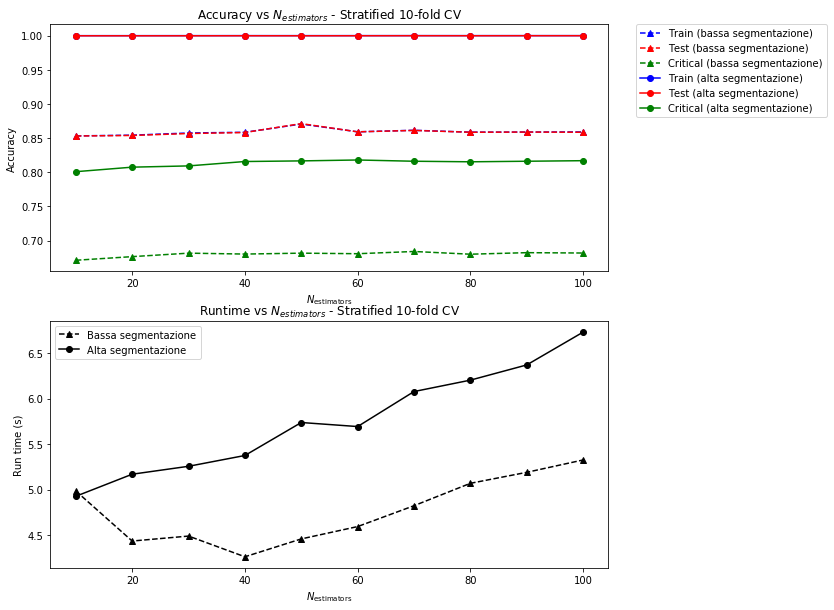

In [0]:
out = train_and_plot(*train_test_critical, ev_method="CV", n_folds=10)
fig, axs = plot_performance(*out)
axs[0].set(title="Accuracy vs $N_{estimators}$ - Stratified 10-fold CV")
axs[1].set(title="Runtime vs $N_{estimators}$ - Stratified 10-fold CV")
plt.show()

Com'era prevedibile, dato che già con 5 folds si aveva `train_accuracy = cv_accuracy`, tale comportamento permane anche con 10 folds. <br>
Di contro, si ha un aumento di circa 1 secondo sul runtime per ogni istanza di fit.

<b> Procediamo ora a implementare il singolo Decision Tree.</b> <br>
Utilizziamo la classe `DecisionTreeClassifier` definita in `sklearn`. <br>
Valutiamo le prestazioni sia col Gini-index che con la X-entropy come indice di purity e 
con `min_samples_split` in 4 ordini di grandezza diversi.

In [0]:
from sklearn.tree import DecisionTreeClassifier
leaf_size_list = [2, 10, 100, 1000, 10000]
out = train_and_plot(
    *train_test_critical, ev_method="CV",
    classifier=DecisionTreeClassifier,
    default_par={
        "criterion": "gini",
        "max_depth": None, 
        "random_state": 0,
    },
    test_par={
        "criterion": ["gini", "entropy"],
        "min_samples_split": leaf_size_list,
    }
)

criterion: gini, min_samples_split: 2
train score    CV estimate    test score     critical score time (s)       
0.9983         0.9918         0.9907         0.6993         51.6982        
criterion: gini, min_samples_split: 10
train score    CV estimate    test score     critical score time (s)       
0.9969         0.9901         0.9886         0.7038         44.5600        
criterion: gini, min_samples_split: 100
train score    CV estimate    test score     critical score time (s)       
0.9862         0.9815         0.9802         0.6871         45.8138        
criterion: gini, min_samples_split: 1000
train score    CV estimate    test score     critical score time (s)       
0.9532         0.9450         0.9499         0.6217         45.0350        
criterion: gini, min_samples_split: 10000
train score    CV estimate    test score     critical score time (s)       
0.8408         0.8362         0.8375         0.6023         33.1213        
criterion: entropy, min_samples_split: 2

Il miglior risultato di accuracy per configurazioni vicine alla temperatura critica si ottiene a media segmentazione, con `min_samples_split=100`, usando la crossentropia come indice di purity e vale 70.49%. Esso, come ci aspettavamo, è inferiore al miglior risultato ottenuto con bagging.
Notiamo però che l'algoritmo non overfitta, in quando lo score sul campione di test è sempre ragionevolmente vicino a quello sul campione di train. Si nota inoltre un grande aumento dei tempi di calcolo.

<b> Procediamo ora con l'implementazione del Gradient Boosting</b>, utilizzando xgboost, provvedendo ad attivare la GPU di Colab. <br>
I valori dei iperparametri sono stati scelti tramite trial-and-error, 
confidando sull'estrema velocità dell'algoritmo. <br>

I risultati, se confrontati con quelli precedenti ottenuti con `sklearn` sono semplicemente straordinari, sia riguardo alla velocità di esecuzione che riguardo all'accuratezza ottenuta. Essa infatti è del 100% sui campioni di train e test e del 82% sulle configurazioni vicine alla temperatura critica, classificandosi come miglior risultato ottenuto in questo notebook.


In [0]:
import numpy as np
import os
import xgboost as xgb
import time
!nvidia-smi

time_start = time.time()
xg_train = xgb.DMatrix(X_train, label=Y_train)
xg_test = xgb.DMatrix(X_test, label=Y_test)
xg_critical = xgb.DMatrix(X_critical, label=Y_critical)

param = {
    # use softmax multi-class classification
    'objective': 'multi:softmax',
    # scale weight of positive examples
    'eta': 0.5,
    'max_depth': 3,
    'silent': 0,
    'num_class': 2,
    'gpu_id': 0,
    #'max_bin': 6,
    'tree_method': 'gpu_hist',
}
# watchlist allows us to monitor the evaluation result on all data in the list 
watchlist = [(xg_train, 'train'), (xg_test, 'test'), (xg_critical, "critical")]
num_round = 120

bst = xgb.train(param, xg_train, num_round, watchlist)

print(time.time() - time_start)

Fri Apr 17 14:31:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    37W / 250W |   3911MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

<b> Procediamo ora alla regressione </b>, provando ad inferire la temperatura dalla configurazione, tramite xgboost. <br>
A tal proposito in figura si osserva il grafico della magnetizzazione spontanea (in modulo) in funzione della temperatura. Si può notare la transizione di fase, non esattamente "sharp", a causa del fatto che, con una griglia 28x28, siamo lontani dal limite termodinamico. <br>
Si notano inoltre molti outlier (a volte perfino allineati) a basse temperature, che non sappiamo come spiegare se non ammettendo una simulazione non perfetta, probabilmente per motivi numerici.

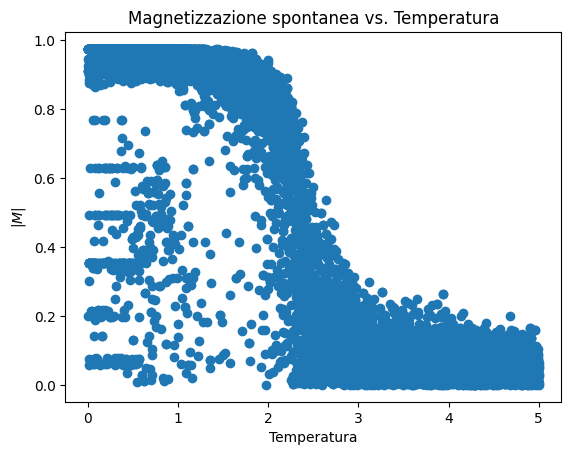

In [0]:
rnd_indexes = np.random.permutation(labels.shape[0])[:10000]
data_subset = data[rnd_indexes, ...]
labels_subset = labels[rnd_indexes, ...]
magn_subset = np.array([np.abs(conf.mean()) for conf in data_subset])
plt.scatter(labels_subset, magn_subset)
plt.title("Magnetizzazione spontanea vs. Temperatura")
plt.xlabel("Temperatura")
plt.ylabel("$|M|$")
plt.show()

Utilizziamo XGBoost per la regressione, senza escludere nessun punto del dataset. L'algoritmo è stato fermato non appena abbiamo osservato un aumento del validation error.

In [0]:
time_start = time.time()
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2)
X_train = np.reshape(X_train, (X_train.shape[0], 28*28))
X_test = np.reshape(X_test, (X_test.shape[0], 28*28))

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3)

xg_train = xgb.DMatrix(X_train, label=Y_train)
xg_val = xgb.DMatrix(X_val, label=Y_val)
xg_test = xgb.DMatrix(X_test, label=Y_test)

param = {
    # use softmax multi-class classification
    'objective': 'reg:squarederror',
    # scale weight of positive examples
    'eta': 0.05,
    'max_depth': 15,
    'silent': 0,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
}
# watchlist allows us to monitor the evaluation result on all data in the list 
watchlist = [(xg_train, 'train'), (xg_val, 'val')]
num_round = 2000

bst = xgb.train(param, xg_train, num_round, watchlist)

print(time.time() - time_start)

Si mostra in figura l'istogramma dei residui della regressione, che mostra uno sbilanciamento verso sinistra della media, causato molto probabilmente dalla presenza degli outlier prima osservati.
Tale sbilanciamento corrisponde all'incirca a un decimo della deviazione standard, per cui, considerando anche il grande numero di punti in questione, va considerato rilevante.

RMSE: 0.26633262767858484
Mean: 0.035739215142876535
mean/rmse: 0.1341901495674322


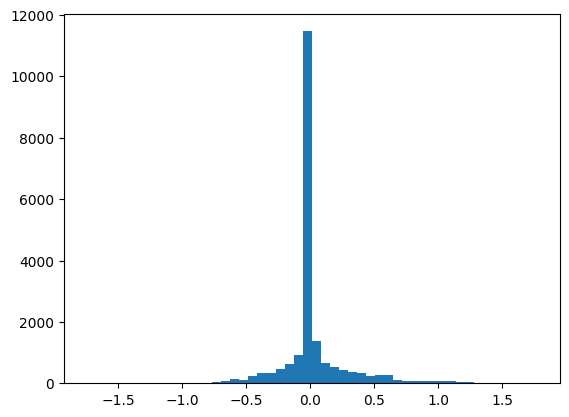

In [0]:
pred = bst.predict(xg_test)
residues = pred - Y_test
std, mean = np.std(residues), np.mean(residues)
print(f"RMSE: {std}")
print(f"Mean: {mean}")
print(f"mean/rmse: {mean/std}")
plt.hist(residues, bins=50)
plt.show()

Mostriamo infine a confronto due grafici:
* magnetizzazione spontanea vs. temperatura reale (a sinistra)
* magnetizzazione spontanea vs. temperatura predetta da XGBoost (a destra)

Si osserva un grande somiglianza tra le due figure, nonostante qualche difficoltà ad approssimare la regione della transizione di fase. <br>
Si verifica inoltre che la regressione ha perfino accennato a riprodurre gli artefatti consistenti nell'allineamento degli outlier nella parte centrale a sinistra dei grafici.

Riteniamo dunque la regressione, al di là della presenza degli outlier, molto ben riuscita.

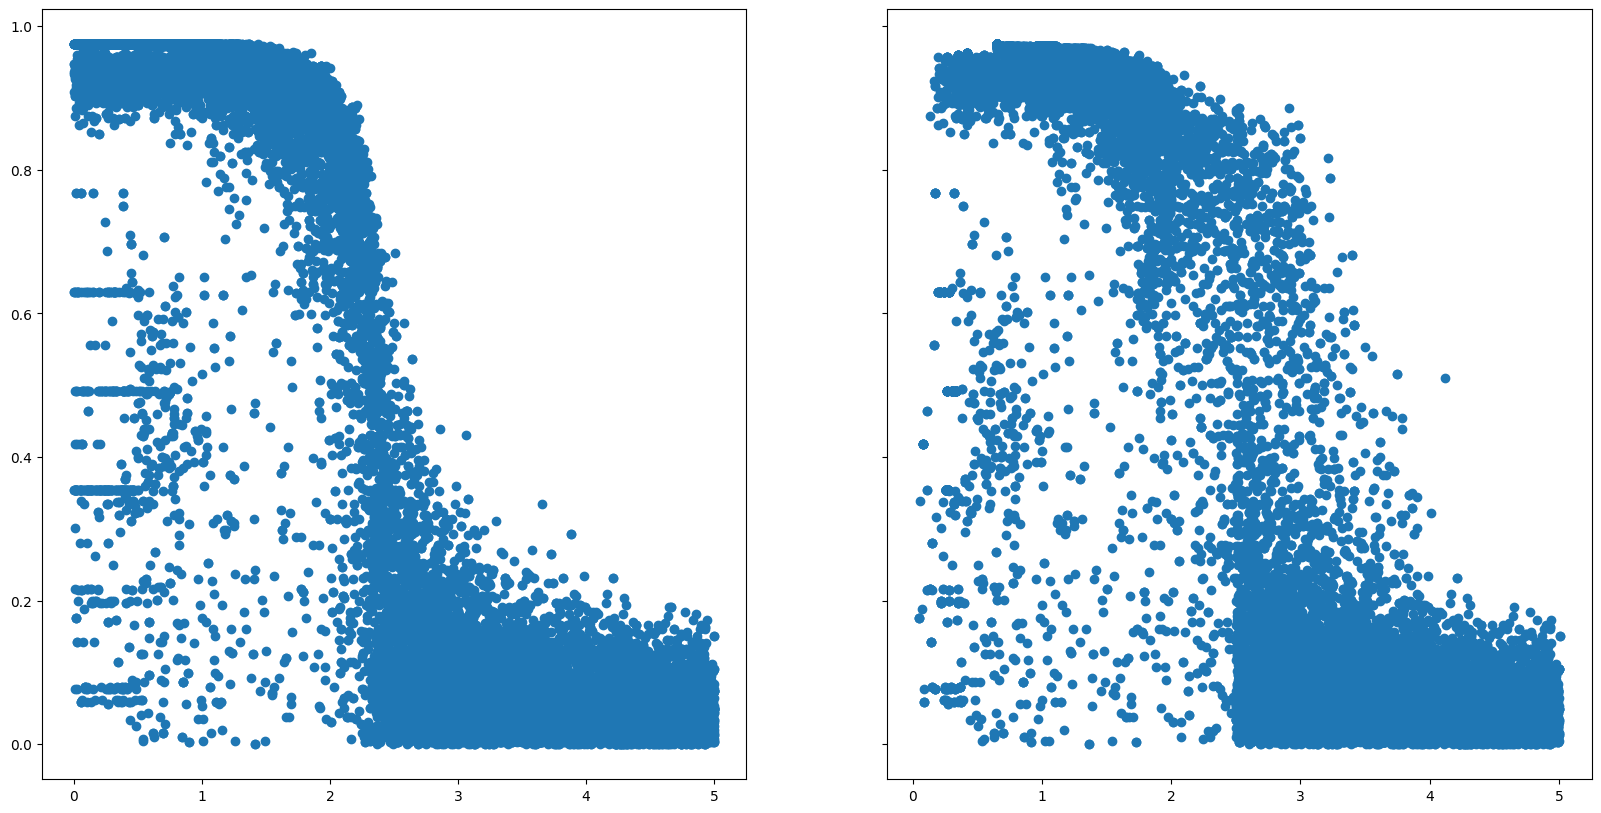

In [0]:
magn_subset = np.array([np.abs(conf.mean()) for conf in X_test])
fig, (sx, dx) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
sx.scatter(Y_test, magn_subset)
dx.scatter(pred, magn_subset)
plt.show()